### Initial Hotspot Prediction Model
##### Goal: Identify high-demand zones at specific times, based on historical trip pickup patterns


#### Load Trip Data

In [416]:
import pandas as pd
import numpy as np
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import datetime
from sklearn.metrics import (
    f1_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score, accuracy_score
)
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
import geopandas as gpd
from shapely.geometry import Polygon

In [417]:
# Load your dataset
print("Current working directory:", os.getcwd())

# Let user select their local file
#Tk().withdraw()  # Hide the root window
file_path = askopenfilename(title="Select your local final cleaned taxi data CSV")

# Check and load
if not file_path or not os.path.exists(file_path):
    raise FileNotFoundError("File not found or not selected.")
else:
    df = pd.read_csv(file_path)
    print("Loaded file:", file_path)
    print("Initial shape:", df.shape)
print(f"Dataset loaded successfully! Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Current working directory: /Users/elliekavanagh/TaxiApp/Notebooks/Hotspot Prediction Model
Loaded file: /Users/elliekavanagh/Downloads/Clean_Jan_Feb_Taxi.csv
Initial shape: (5681617, 21)
Dataset loaded successfully! Shape: (5681617, 21)
Columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour', 'pickup_day_of_week', 'droppoff_date', 'pickup_borough', 'pickup_zone', 'pickup_service_zone', 'dropoff_borough', 'dropoff_zone', 'dropoff_service_zone', 'fare_per_minute', 'trip_speed', 'trip_speed_mph', 'time_of_day', 'day_type', 'is_weekend']


#### Shapefile Adjacency List

In [418]:
# Prompt user to select a shapefile
shapefile_path = askopenfilename(title="Select your shapefile")

# Check and load
if not shapefile_path or not os.path.exists(shapefile_path):
    raise FileNotFoundError("File not found or not selected.")

# Read shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)
print("Loaded shapefile:", shapefile_path)
print("Initial shape:", gdf.shape)
print("Columns:", list(gdf.columns))

# Define the name of the zone column (update this if needed)
zone_column = "zone"  

Loaded shapefile: /Users/elliekavanagh/Downloads/taxi_zones (1)/taxi_zones.shp
Initial shape: (263, 7)
Columns: ['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry']


In [419]:
# Initialize adjacency list
adjacency_list = {zone: [] for zone in gdf[zone_column]}

# Build adjacency based on touching or nearly touching boundaries
for idx1, row1 in gdf.iterrows():
    zone1 = row1[zone_column] # Current zone
    geom1 = row1.geometry # Geometry of the current zone
    for idx2, row2 in gdf.iterrows():
        if idx1 != idx2: # Skip self-comparison
            zone2 = row2[zone_column]
            geom2 = row2.geometry
            # Check if two zones are adjacent
            if geom1.touches(geom2) or geom1.buffer(0.0001).intersects(geom2):
                adjacency_list[zone1].append(zone2) # Add zone2 as a neighbor of zone1

# Remove duplicates from adjacency list
adjacency_list = {k: list(set(v)) for k, v in adjacency_list.items()}

#### Preprocessing: Creating Datetime Features and Dropping Features

In [420]:
# Convert date columns to datetime
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [421]:
# Base holidays + extra fun/party days
holidays = [
    '2023-01-01',  # New Year's Day
    '2023-01-16',  # Martin Luther King Jr. Day
    '2023-02-14',  # Valentine's Day
    '2023-02-20',  # Presidents' Day
    '2023-03-17',  # St. Patrick's Day
    '2023-05-29',  # Memorial Day
    '2023-06-19',  # Juneteenth
    '2023-06-25',  # NYC Pride Parade (last Sunday in June)
    '2023-07-03',  # Night before Independence Day
    '2023-07-04',  # Independence Day
    '2023-09-04',  # Labor Day
    '2023-10-31',  # Halloween
    '2023-11-05',  # NYC Marathon (1st Sunday of November)
    '2023-11-22',  # Night before Thanksgiving
    '2023-11-23',  # Thanksgiving Day
    '2023-11-24',  # Black Friday (shopping traffic)
    '2023-12-09',  # SantaCon (bar crawl event)
    '2023-12-23',  # Night before Christmas Eve
    '2023-12-24',  # Christmas Eve
    '2023-12-25',  # Christmas Day
    '2023-12-31',  # New Year's Eve
]

df['is_holiday'] = df['tpep_pickup_datetime'].dt.date.isin(pd.to_datetime(holidays).date)

In [422]:
# Add pickup month
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
# Add pickup minute
df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute

In [489]:
df['day_time_interaction'] = df['pickup_day_of_week'].astype(str) + "_" + df['time_of_day'].astype(str)
df['zone_hour_interaction'] = df['pickup_zone'].astype(str) + "_" + df['pickup_hour'].astype(str)
df['holiday_time_interaction'] = df['is_holiday'].astype(str) + '_' + df['time_of_day'].astype(str)
df['zone_isweekend_interaction'] = df['pickup_zone'].astype(str) + '_' + df['is_weekend'].astype(str)
df['hour_isweekend_interaction'] = df['pickup_hour'].astype(str) + '_' + df['is_weekend'].astype(str)
df['zone_time_isweekend_interaction'] = df['pickup_zone'].astype(str) + '_' + df['time_of_day'].astype(str) + "_" + df['is_weekend'].astype(str)
df['zone_hour_isweekend_interaction'] = df['pickup_zone'].astype(str) + '_' + df['pickup_hour'].astype(str) + "_" + df['is_weekend'].astype(str)
df['zone_hour_holiday_interaction'] = df['pickup_zone'].astype(str) + '_' + df['pickup_hour'].astype(str) + "_" + df['is_holiday'].astype(str)

In [490]:
# Drop the below features - Not needed for classifying a zone as a hotspot
columns_to_drop = [
    'fare_amount', 'fare_per_minute', 'trip_distance', 'trip_speed', 'dropoff_service_zone', 'trip_duration_min', 'dropoff_borough', 'dropoff_zone',
    'droppoff_date', 'trip_speed_mph'
]
df.drop(columns=columns_to_drop, inplace=True)

KeyError: "['fare_amount', 'fare_per_minute', 'trip_distance', 'trip_speed', 'dropoff_service_zone', 'trip_duration_min', 'dropoff_borough', 'dropoff_zone', 'droppoff_date', 'trip_speed_mph'] not found in axis"

#### Aggregating Trips By Zone, Pickup Time, and Day of Week

In [492]:
# Group by zone and hour (can adjust time granularity)
zone_time_df = df.groupby([
    'pickup_zone', 'pickup_date', 'pickup_month', 'day_time_interaction', 'zone_hour_interaction', 'zone_isweekend_interaction', 'holiday_time_interaction', 'hour_isweekend_interaction', 'zone_time_isweekend_interaction', 'zone_hour_isweekend_interaction', 'zone_hour_holiday_interaction', 'pickup_hour', 'pickup_day_of_week', 'is_weekend', 'time_of_day', 'is_holiday']).agg({
    'tpep_pickup_datetime': 'count'
}).reset_index().rename(columns={'tpep_pickup_datetime': 'trip_count'})

zone_mean = zone_time_df.groupby('pickup_zone')['trip_count'].transform('mean')
zone_time_df['trip_count_norm'] = zone_time_df['trip_count'] / zone_mean


Discussion:
- The trip count for a given zone and time is divided by that zone's average trip count across all records
- trip_count_norm represents how much or below the average activity for that zone at a particular time
- Removes zone-level bias (not comparing absolute trip counts across zones, but relative activity within each zone)

In [469]:
def get_neighbor_trip_stats(current_date, hour, neighbors, source_df):
    # Filter historical trips for given hour, before the current date, and for neighbor zones
    mask = (
        (source_df['pickup_date'] < current_date) & 
        (source_df['pickup_hour'] == hour) &
        (source_df['pickup_zone'].isin(neighbors))
    )
    
    filtered = source_df[mask]
    
    if len(filtered) > 0:
        trips = filtered['trip_count']
        trips_norm = filtered['trip_count_norm']
        
        return {
            'neighbor_mean_trip': trips.mean(),
            'neighbor_std_trip': trips.std(),
            'neighbor_max_trip': trips.max(),
            'neighbor_min_trip': trips.min(),
            'neighbor_mean_trip_norm': trips_norm.mean(),
            'neighbor_std_trip_norm': trips_norm.std(),
            'neighbor_max_trip_norm': trips_norm.max(),
            'neighbor_min_trip_norm': trips_norm.min(),
            'neighbor_count': len(trips)
        }
    else:
        # Return 0s if no historical data is found
        return {
            'neighbor_mean_trip': 0.0,
            'neighbor_std_trip': 0.0,
            'neighbor_max_trip': 0.0,
            'neighbor_min_trip': 0.0,
            'neighbor_mean_trip_norm': 0.0,
            'neighbor_std_trip_norm': 0.0,
            'neighbor_max_trip_norm': 0.0,
            'neighbor_min_trip_norm': 0.0,
            'neighbor_count': 0
        }


In [470]:
# Initialize lists to collect each feature
stats_cols = [
    'neighbor_mean_trip', 'neighbor_std_trip', 'neighbor_max_trip', 'neighbor_min_trip',
    'neighbor_mean_trip_norm', 'neighbor_std_trip_norm', 'neighbor_max_trip_norm', 'neighbor_min_trip_norm',
    'neighbor_count'
]
neighbor_stats = {col: [] for col in stats_cols}

# Iterate through each row to compute neighbor stats
for idx, row in zone_time_df.iterrows():
    zone = row['pickup_zone']
    hour = row['pickup_hour']
    date = row['pickup_date']
    neighbors = adjacency_list.get(zone, [])
    
    # Skip if no neighbors
    if not neighbors:
        for col in stats_cols:
            neighbor_stats[col].append(0.0)
        continue

    # Get all neighbor statistics
    stats = get_neighbor_trip_stats(date, hour, neighbors, zone_time_df)
    
    for col in stats_cols:
        neighbor_stats[col].append(stats[col])
    
    # Optional progress logging
    if idx % 1000 == 0:
        print(f"Processed {idx} rows...")

Processed 0 rows...
Processed 1000 rows...
Processed 2000 rows...
Processed 3000 rows...
Processed 4000 rows...
Processed 5000 rows...
Processed 6000 rows...
Processed 7000 rows...
Processed 8000 rows...
Processed 9000 rows...
Processed 10000 rows...
Processed 11000 rows...
Processed 12000 rows...
Processed 13000 rows...
Processed 14000 rows...
Processed 15000 rows...
Processed 16000 rows...
Processed 17000 rows...
Processed 18000 rows...
Processed 19000 rows...
Processed 20000 rows...
Processed 21000 rows...
Processed 22000 rows...
Processed 23000 rows...
Processed 24000 rows...
Processed 25000 rows...
Processed 26000 rows...
Processed 27000 rows...
Processed 28000 rows...
Processed 29000 rows...
Processed 30000 rows...
Processed 31000 rows...
Processed 32000 rows...
Processed 33000 rows...
Processed 34000 rows...
Processed 35000 rows...
Processed 36000 rows...
Processed 37000 rows...
Processed 38000 rows...
Processed 39000 rows...
Processed 40000 rows...
Processed 41000 rows...
Proce

In [493]:
# Append all computed features to the dataframe
for col in stats_cols:
    zone_time_df[col] = neighbor_stats[col]
    
zone_time_df['neighbor_std_trip'] = zone_time_df['neighbor_std_trip'].clip(upper=zone_time_df['neighbor_std_trip'].quantile(0.95))

In [494]:
# Sort by time within each pickup zone
zone_time_df = zone_time_df.sort_values(by=['pickup_zone', 'pickup_date', 'pickup_hour'])

In [495]:
zone_time_df.sort_values(by='trip_count_norm', ascending=False)

,pickup_zone,pickup_date,pickup_month,day_time_interaction,zone_hour_interaction,zone_isweekend_interaction,holiday_time_interaction,hour_isweekend_interaction,zone_time_isweekend_interaction,zone_hour_isweekend_interaction,...,trip_count_norm,neighbor_mean_trip,neighbor_std_trip,neighbor_max_trip,neighbor_min_trip,neighbor_mean_trip_norm,neighbor_std_trip_norm,neighbor_max_trip_norm,neighbor_min_trip_norm,neighbor_count
467,Alphabet City,2023-01-22,1,6_Early Morning,Alphabet City_2,Alphabet City_True,False_Early Morning,2_True,Alphabet City_Early Morning_True,Alphabet City_2_True,...,12.389821,84.508197,100.146940,517.0,1.0,1.766106,2.407847,8.697531,0.069766,61.0
117511,Williamsburg (South Side),2023-01-01,1,6_Early Morning,Williamsburg (South Side)_3,Williamsburg (South Side)_True,True_Early Morning,3_True,Williamsburg (South Side)_Early Morning_True,Williamsburg (South Side)_3_True,...,12.064865,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
44382,Greenpoint,2023-01-01,1,6_Early Morning,Greenpoint_2,Greenpoint_True,True_Early Morning,2_True,Greenpoint_Early Morning_True,Greenpoint_2_True,...,12.037935,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1322,Astoria,2023-01-01,1,6_Early Morning,Astoria_2,Astoria_True,True_Early Morning,2_True,Astoria_Early Morning_True,Astoria_2_True,...,11.964663,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
66136,Long Island City/Queens Plaza,2023-02-23,2,3_Evening Rush,Long Island City/Queens Plaza_17,Long Island City/Queens Plaza_False,False_Evening Rush,17_False,Long Island City/Queens Plaza_Evening Rush_False,Long Island City/Queens Plaza_17_False,...,11.855460,2.154839,1.264613,9.0,1.0,0.990014,0.593542,4.847022,0.335286,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108560,Upper East Side South,2023-02-23,2,3_Early Morning,Upper East Side South_2,Upper East Side South_False,False_Early Morning,2_False,Upper East Side South_Early Morning_False,Upper East Side South_2_False,...,0.005077,13.829932,19.094296,171.0,1.0,0.127720,0.186458,1.643445,0.005398,294.0
108061,Upper East Side South,2023-02-02,2,3_Early Morning,Upper East Side South_3,Upper East Side South_False,False_Early Morning,3_False,Upper East Side South_Early Morning_False,Upper East Side South_3_False,...,0.005077,9.423313,12.840376,84.0,1.0,0.086862,0.121550,0.789764,0.005398,163.0
108394,Upper East Side South,2023-02-16,2,3_Early Morning,Upper East Side South_3,Upper East Side South_False,False_Early Morning,3_False,Upper East Side South_Early Morning_False,Upper East Side South_3_False,...,0.005077,8.743697,11.508090,84.0,1.0,0.080207,0.108670,0.789764,0.005398,238.0
108680,Upper East Side South,2023-02-28,2,1_Early Morning,Upper East Side South_2,Upper East Side South_False,False_Early Morning,2_False,Upper East Side South_Early Morning_False,Upper East Side South_2_False,...,0.005077,13.990683,18.749951,171.0,1.0,0.129250,0.183301,1.643445,0.005398,322.0


In [496]:
# Use threshold on normalized trip count to categorize hotspot (top 20%)
threshold = zone_time_df['trip_count_norm'].quantile(0.80)
zone_time_df['is_hotspot'] = (zone_time_df['trip_count_norm'] >= threshold).astype(int)

# Sort to inspect
zone_time_df.sort_values(by=['trip_count_norm', 'is_hotspot'], ascending=False, inplace=True)
zone_time_df

,pickup_zone,pickup_date,pickup_month,day_time_interaction,zone_hour_interaction,zone_isweekend_interaction,holiday_time_interaction,hour_isweekend_interaction,zone_time_isweekend_interaction,zone_hour_isweekend_interaction,...,neighbor_mean_trip,neighbor_std_trip,neighbor_max_trip,neighbor_min_trip,neighbor_mean_trip_norm,neighbor_std_trip_norm,neighbor_max_trip_norm,neighbor_min_trip_norm,neighbor_count,is_hotspot
467,Alphabet City,2023-01-22,1,6_Early Morning,Alphabet City_2,Alphabet City_True,False_Early Morning,2_True,Alphabet City_Early Morning_True,Alphabet City_2_True,...,84.508197,100.146940,517.0,1.0,1.766106,2.407847,8.697531,0.069766,61.0,1
117511,Williamsburg (South Side),2023-01-01,1,6_Early Morning,Williamsburg (South Side)_3,Williamsburg (South Side)_True,True_Early Morning,3_True,Williamsburg (South Side)_Early Morning_True,Williamsburg (South Side)_3_True,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1
44382,Greenpoint,2023-01-01,1,6_Early Morning,Greenpoint_2,Greenpoint_True,True_Early Morning,2_True,Greenpoint_Early Morning_True,Greenpoint_2_True,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1
1322,Astoria,2023-01-01,1,6_Early Morning,Astoria_2,Astoria_True,True_Early Morning,2_True,Astoria_Early Morning_True,Astoria_2_True,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1
66136,Long Island City/Queens Plaza,2023-02-23,2,3_Evening Rush,Long Island City/Queens Plaza_17,Long Island City/Queens Plaza_False,False_Evening Rush,17_False,Long Island City/Queens Plaza_Evening Rush_False,Long Island City/Queens Plaza_17_False,...,2.154839,1.264613,9.0,1.0,0.990014,0.593542,4.847022,0.335286,155.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108560,Upper East Side South,2023-02-23,2,3_Early Morning,Upper East Side South_2,Upper East Side South_False,False_Early Morning,2_False,Upper East Side South_Early Morning_False,Upper East Side South_2_False,...,13.829932,19.094296,171.0,1.0,0.127720,0.186458,1.643445,0.005398,294.0,0
108561,Upper East Side South,2023-02-23,2,3_Early Morning,Upper East Side South_3,Upper East Side South_False,False_Early Morning,3_False,Upper East Side South_Early Morning_False,Upper East Side South_3_False,...,8.644928,10.998711,84.0,1.0,0.079410,0.104046,0.789764,0.005398,276.0,0
108657,Upper East Side South,2023-02-27,2,0_Early Morning,Upper East Side South_3,Upper East Side South_False,False_Early Morning,3_False,Upper East Side South_Early Morning_False,Upper East Side South_3_False,...,8.839465,10.945302,84.0,1.0,0.081398,0.103695,0.789764,0.005398,299.0,0
108680,Upper East Side South,2023-02-28,2,1_Early Morning,Upper East Side South_2,Upper East Side South_False,False_Early Morning,2_False,Upper East Side South_Early Morning_False,Upper East Side South_2_False,...,13.990683,18.749951,171.0,1.0,0.129250,0.183301,1.643445,0.005398,322.0,0


#### Drop Trip Count (To Prevent Data Leakage)

In [497]:
zone_time_df.drop(columns='trip_count', inplace=True)
zone_time_df.drop(columns='trip_count_norm', inplace=True)

#### Split by Time Jan = Train, Feb = Test

In [498]:
# Ensure your date ranges are accurate
jan_mask = zone_time_df['pickup_date'].dt.month == 1
feb_mask = zone_time_df['pickup_date'].dt.month == 2

train_df = zone_time_df[jan_mask].copy()
test_df = zone_time_df[feb_mask].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (64047, 26)
Test shape: (59141, 26)


#### Define Target and Features

In [499]:
# Define target and features
target_column = 'is_hotspot'

# Ensure target column exists
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]

X_test = test_df.drop(columns=[target_column])
y_test = test_df[target_column]

# Add target back for encoding 
X_train_full = X_train.copy()
X_train_full['is_hotspot'] = y_train

X_test_full = X_test.copy()
X_test_full['is_hotspot'] = y_test

#### Encoding

In [500]:
# Base encoding 
def base_encode(df):
    df_encoded = df.copy()
    df_encoded['is_weekend'] = df_encoded['is_weekend'].astype(int)
    time_order = {
        'Early Morning': 0, 'Morning Rush': 1, 'Midday': 2, 'Evening Rush': 3, 'Night': 4
    }
    df_encoded['time_of_day_encoded'] = df_encoded['time_of_day'].map(time_order)
    df_encoded.drop('time_of_day', axis=1, inplace=True)
    return df_encoded

#  Target Encoding 
def target_encode_train_and_apply(train_df, test_df, target_column, zone_column):
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for col in zone_column:
        new_col = f"{col}_target_encoded"
        train_encoded[new_col] = np.nan
        for train_idx, val_idx in kf.split(train_df):
            train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]
            means = train_fold.groupby(col)[target_column].mean()
            train_encoded.loc[val_fold.index, new_col] = val_fold[col].map(means)
        final_means = train_df.groupby(col)[target_column].mean()
        test_encoded[new_col] = test_df[col].map(final_means)
        train_encoded.drop(columns=col, inplace=True)
        test_encoded.drop(columns=col, inplace=True)
    return train_encoded, test_encoded


#  Base encode the full data with target temporarily added
train_base = base_encode(X_train_full)
test_base = base_encode(X_test_full)

#  Target encode the zone columns
train_encoded, test_encoded = target_encode_train_and_apply(
    train_base, test_base,
    target_column='is_hotspot',
    zone_column=['pickup_zone', 'day_time_interaction', 'zone_hour_interaction', 'holiday_time_interaction', 'zone_isweekend_interaction', 'hour_isweekend_interaction', 'zone_time_isweekend_interaction', 'zone_hour_isweekend_interaction', 'zone_hour_holiday_interaction']
)

In [501]:
#  Drop datetime columns
for col in ['pickup_date', 'tpep_pickup_datetime']:
    train_encoded.drop(columns=col, errors='ignore', inplace=True)
    test_encoded.drop(columns=col, errors='ignore', inplace=True)

#  NOW drop the target from the features
X_train_final = train_encoded.drop(columns=['is_hotspot'])
X_test_final = test_encoded.drop(columns=['is_hotspot'])

# Final check
print("Final training columns:", X_train_final.columns)

Final training columns: Index(['pickup_month', 'pickup_hour', 'pickup_day_of_week', 'is_weekend',
       'is_holiday', 'neighbor_mean_trip', 'neighbor_std_trip',
       'neighbor_max_trip', 'neighbor_min_trip', 'neighbor_mean_trip_norm',
       'neighbor_std_trip_norm', 'neighbor_max_trip_norm',
       'neighbor_min_trip_norm', 'neighbor_count', 'time_of_day_encoded',
       'pickup_zone_target_encoded', 'day_time_interaction_target_encoded',
       'zone_hour_interaction_target_encoded',
       'holiday_time_interaction_target_encoded',
       'zone_isweekend_interaction_target_encoded',
       'hour_isweekend_interaction_target_encoded',
       'zone_time_isweekend_interaction_target_encoded',
       'zone_hour_isweekend_interaction_target_encoded',
       'zone_hour_holiday_interaction_target_encoded'],
      dtype='object')


#### Train and Evaluate XGBoost

**Notes on Parameters for Tuning**
- Learning Rate (learning_rate)
    - Step size shrinkage used in update to prevent overfitting
    - After each boosting step, can directly get the weights of new features
    - Lower values (e.g., 0.01 - 0.1) make learning slower but usually more accurate when combined with more trees (n_estimators)
- Max Depth (max_depth)
    - Controls model complexity; deeper trees can overfit
- scale_pos_weight
    - Controls the balance of positive and negative weights, useful for unbalanced classes
    - A typical value to consider: sum(negative instances) / sum(positive instances)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 4.3274829479287975}
Metrics at Threshold = 0.5:
F1 Score: 0.6277418536832763
Precision: 0.523223249669749
Recall: 0.7844410995801315
Accuracy: 0.8014237162036489
AUC: 0.8828212524704285
Confusion Matrix:
 [[37495  9023]
 [ 2721  9902]]

Best Threshold for F1: 0.60
Metrics at Best Threshold:
F1 Score: 0.6540104413858566
Precision: 0.6530289866519232
Recall: 0.654994850669413
Accuracy: 0.8520823117634129
AUC: 0.8828212524704285
Confusion Matrix:
 [[42125  4393]
 [ 4355  8268]]


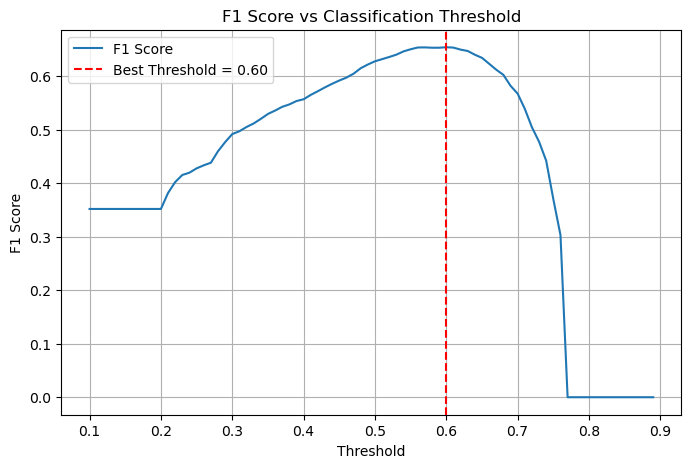

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

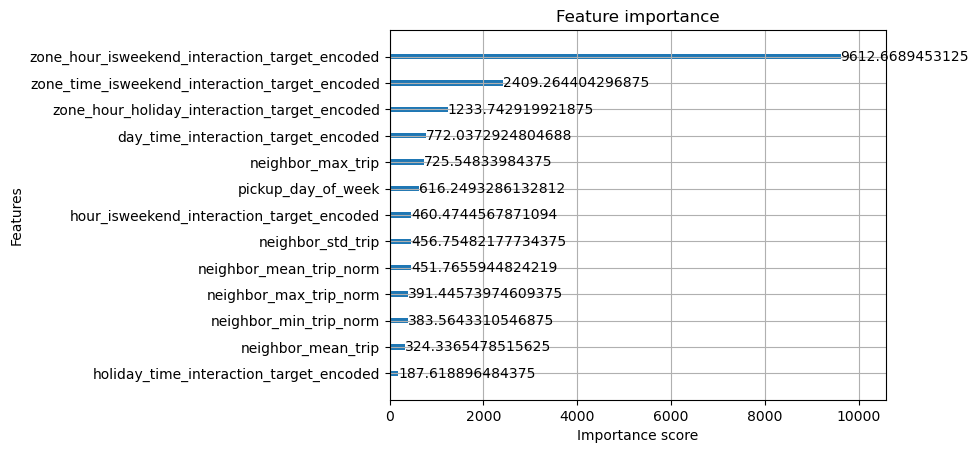

In [502]:
# Prepare data
X_train = train_encoded.drop(columns='is_hotspot')
y_train = train_encoded['is_hotspot']
X_test = test_encoded.drop(columns='is_hotspot')
y_test = test_encoded['is_hotspot']

# Calculate class imbalance ratio
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

# Define model
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    verbosity=0
)

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'scale_pos_weight': [1, scale_pos_weight, scale_pos_weight ** 0.5],
}

# Grid search with F1 optimization, search for best combinations of hyperparameters
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid.fit(X_train, y_train)

# Evaluate best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics at default threshold 0.5
print("Best Parameters:", grid.best_params_)
print("Metrics at Threshold = 0.5:")
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Search for best F1 threshold
thresholds = np.arange(0.1, 0.9, 0.01)
f1s = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1s)]

# Apply best threshold
y_pred_best = (y_proba >= best_threshold).astype(int)

# Metrics at best threshold
print(f"\nBest Threshold for F1: {best_threshold:.2f}")
print(f"Metrics at Best Threshold:")
print("F1 Score:", max(f1s))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

# Plot F1 score vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.title('F1 Score vs Classification Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot feature importance for the best model
xgb.plot_importance(best_model, max_num_features=15, importance_type='gain')

#### Train and Evaluate LightGBM

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2.080260307732856; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=4.3274829479287975; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2.080260307732856; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=4.3274829479287975; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=4.3274829479287975; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, sca

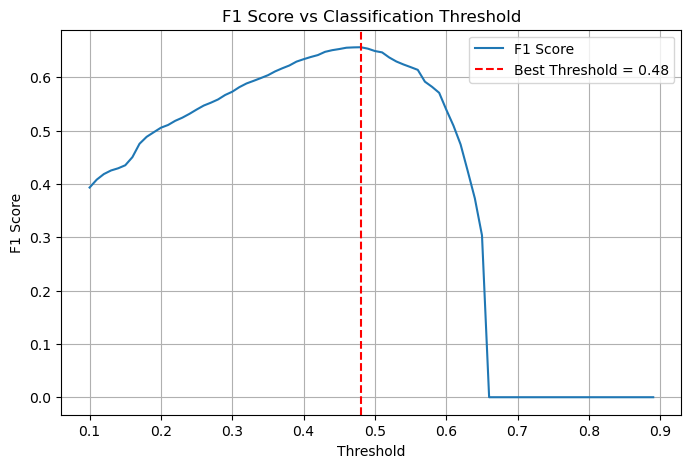

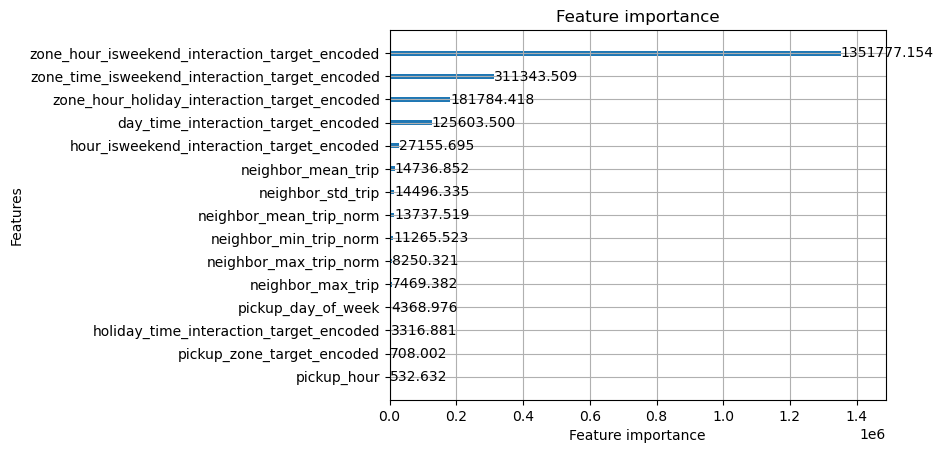

In [503]:
# Prepare data
X_train = train_encoded.drop(columns='is_hotspot')
y_train = train_encoded['is_hotspot']
X_test = test_encoded.drop(columns='is_hotspot')
y_test = test_encoded['is_hotspot']

# Calculate class imbalance ratio
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

# Define LightGBM model
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    metric='binary_logloss',
    verbose=-1, 
    n_jobs=-1, # Number of threads
    random_state=42
)

# Parameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'scale_pos_weight': [1, scale_pos_weight, scale_pos_weight ** 0.5],
    'n_estimators': [100, 200]  # Add n_estimators to grid to control rounds
}

# Use F1 scorer for GridSearchCV
f1_scorer = make_scorer(f1_score)

# Grid search with 3-fold CV, optimizing F1
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit grid search
grid.fit(X_train, y_train)

# Best model from grid search
best_model = grid.best_estimator_

# Predict probabilities on test
y_proba = best_model.predict_proba(X_test)[:, 1]

# Default threshold = 0.5 predictions
y_pred = (y_proba >= 0.5).astype(int)

# Metrics at threshold 0.5
print("Best Parameters:", grid.best_params_)
print("Metrics at Threshold = 0.5:")
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Search for best F1 threshold
thresholds = np.arange(0.1, 0.9, 0.01)
f1s = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1s)]

# Predictions at best threshold
y_pred_best = (y_proba >= best_threshold).astype(int)

# Metrics at best threshold
print(f"\nBest Threshold for F1: {best_threshold:.2f}")
print(f"Metrics at Best Threshold:")
print("F1 Score:", max(f1s))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

# Plot F1 score vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.title('F1 Score vs Classification Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot feature importance for best model
lgb.plot_importance(best_model, max_num_features=15, importance_type='gain')
plt.show()